In [2]:
from pathlib import Path
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from gym_recording_modified.playback import get_recordings

In [12]:
# plot episode lengths

root = Path('results')

def extract_epsisode_lengths(root: str, param_names: list, env: str, max_length: int=None):
    """
    Extract epsiode lengths

    args
        root : directory where results are stored
        param_names : a list of parameters to extract for each run, stored in params.json 
        env: which environment to extract this for
        max_length: runs that never terminated, 
    """

    all_episodes = []
    all_params = []

    for dir in root.iterdir():    
        params_file = dir/'params.json'               
        params = json.load(open(params_file))

        if params['env'] == env:
                
            params_run  = [] # relevant parameters for a single run
            for p in param_names:
                params_run.append(params.get(p, None))

            all_params.append(params_run)
            episode_len= np.load(dir/"episode_lengths.npy")

            print(episode_len)

            all_episodes.append(episode_len)
        
    return np.array(all_params),  np.array(episode_len)


params, rewards = extract_epsisode_lengths(root, ['model_arch', 'env', 'seed'], "envs:random_maze-v0")

[856]
[856]
[615]
[]
[]
[]
[]
[]
[]
[]
[]
[663]
[364]
[364]
[]
[992]
[992]
[]
[]
[]
[129  65 453  17]
[621 234 118]
[621 234 118]
[]
[996]
[996]
[217]
[]
[]
[662]
[]
[]
[524]
[474]
[474]
[]
[591 169]
[591 169]
[]
[]
[]
[]
[]
[]
[938]
[]
[]
[]
[608]
[608]
[564 306]
[886]
[886]
[]
[303 165  61 322  84]
[303 265 282 146]
[128 482]
[618]
[618]
[]


In [7]:
rewards.shape

(5,)

In [88]:
def extract_rewards(root: str, param_names: list):
    """
    Extract rewards

    args
        root : directory where results are stored
        param_names : a list of parameters to extract for each run, stored in params.json 
    """

    all_rewards = []
    all_params = []

    for dir in root.iterdir():    
        params_file = dir/'params.json'               
        params = json.load(open(params_file))
        params_run  = [] # relevant parameters for a single run
        for p in param_names:
            params_run.append(params.get(p, None))

        all_params.append(params_run)
        rewards = get_recordings(dir, extract='rewards')['rewards']
        all_rewards.append(rewards)
        
    return np.array(all_params),  np.array(all_rewards)


params, rewards = extract_rewards(root, ['model_arch', 'env', 'seed'])

In [89]:
params

array([['FFN', 'envs:random_maze-v0', '8479'],
       ['FFN', 'envs:random_maze-v0', '8479'],
       ['FFN', 'envs:random_maze-v0', '8479'],
       ['FFN', 'envs:random_maze-v0', '9943'],
       ['FFN', 'envs:random_maze-v0', '9943'],
       ['FFN', 'envs:random_maze-v0', '9943'],
       ['FFN', 'envs:random_maze-v0', '5396'],
       ['FFN', 'envs:random_maze-v0', '5396'],
       ['FFN', 'envs:random_maze-v0', '5396'],
       ['FFN', 'envs:random_maze-v0', '3211'],
       ['FFN', 'envs:random_maze-v0', '3211'],
       ['FFN', 'envs:random_maze-v0', '3211'],
       ['FFN', 'envs:random_maze-v0', '545'],
       ['FFN', 'envs:random_maze-v0', '545'],
       ['FFN', 'envs:random_maze-v0', '545'],
       ['FFN', 'envs:random_maze-v0', '1321'],
       ['FFN', 'envs:random_maze-v0', '1321'],
       ['FFN', 'envs:random_maze-v0', '1321'],
       ['FFN', 'envs:random_maze-v0', '438'],
       ['FFN', 'envs:random_maze-v0', '438'],
       ['FFN', 'envs:random_maze-v0', '438'],
       ['FFN', 'env

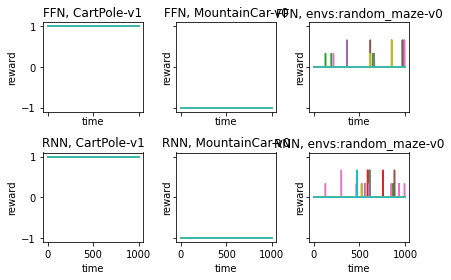

In [94]:
def plot_timesteps(params: np.array, data: np.array, row=None, col=None, plot=None, xlabel='', ylabel='', rowdict={}, coldict={}):
    """
    General-use function for plotting a variable over time

    args: 
        params : np.array shape (num_runs, num_params) with parameters for each run
        data : np.array shape (num_runs, num_timesteps) with data
        row : index of parameters, this function will generate a subplot for each unique setting
        col : index of parameters, this function Will generate a subplot for each unique setting
        plot : index of parameters, for which a new line will be added to a subplot for each unique value
        
    """

    nrows = np.unique(params[:, row]).shape[0]
    ncols = np.unique(params[:, col]).shape[0]

    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, sharey=True, squeeze=False)

    row_idx = 0
    for row_param in np.unique(params[:, row]):
        col_idx = 0
        for col_param in np.unique(params[:, col]):
            for plot_param in np.unique(params[:, plot]):
                inds = np.where(
                    (params[:, row]==row_param) & 
                    (params[:, col]==col_param) & 
                    (params[:, plot]==plot_param))
                
                data_ = np.mean(data[inds], axis=0) # data to plot
                
                ax = axs[row_idx, col_idx]
                ax.plot(data_)
                ax.set_title('%s, %s' % (rowdict.get(row_param, row_param), coldict.get(col_param, colparam)))
                ax.set_xlabel(xlabel)
                ax.set_ylabel(ylabel)

            
            col_idx += 1
        row_idx += 1



    fig.tight_layout()





plot_timesteps(params, rewards, 0, 1, 2, 'time', 'reward')